In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
!pip install ultralytics==8.2.103 -q

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.3/112.6 GB disk)


In [ ]:
from ultralytics import YOLO
from IPython.display import display, Image

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="wUTrgax5Cu895nOge0IQ")
project = rf.workspace("pista").project("pista-detection")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pista-Detection-1 in yolov8:: 100%|██████████| 6012/6012 [00:01<00:00, 4368.00it/s]


In [ ]:
import yaml

with open(f'{dataset.location}/data.yaml', 'r') as f:
    data = yaml.safe_load(f)
data['train'] = '../train/images'
data['val'] = '../valid/images'
data['test'] = '../test/images'
if 'path' in data:
  del data['path']
with open(f'{dataset.location}/data.yaml', 'w') as f:
    yaml.dump(data, f, sort_keys=False)

In [ ]:
import torch
from ultralytics import YOLO
from ultralytics.nn.modules import C2f  # Import C2f module

class CustomYOLO(YOLO):
    def __init__(self, model_path):
        super().__init__(model_path)
        self.add_extra_layers_to_backbone()   # Add extra layers to backbone
        self.add_extra_layers_to_neck()       # Add extra layers to neck
        self.verify_layers()                  # Verify the added layers

    def add_extra_layers_to_backbone(self):
        """ Add extra layers to the backbone. """
        print("\n🔧 Modifying Backbone Layers...")

        if hasattr(self.model.model[0], 'add_module'):
            # Extra layers for high-level feature extraction
            extra_backbone_layers = torch.nn.Sequential(
                torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),   # Extra Conv1
                torch.nn.ReLU(),
                torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),   # Extra Conv2
                torch.nn.ReLU(),
                C2f(256, 256, n=2)                                     # Added C2f block
            )

            # Create a new backbone with extra layers
            new_backbone = torch.nn.Sequential(
                extra_backbone_layers,   # Add extra layers at the start
                *self.model.model[0:]    # Original backbone layers
            )

            # Replace the old backbone with the new one
            self.model.model[0] = new_backbone
            print("✅ Extra layers added to the backbone!\n", extra_backbone_layers)

        else:
            print("⚠️ Warning: Could not modify the YOLOv8 backbone correctly!")

    def add_extra_layers_to_neck(self):
        """ Add extra layers to the neck. """
        print("\n🔧 Modifying Neck Layers...")

        neck_index = 7  # Adding extra layers at neck position

        if isinstance(self.model.model[neck_index], torch.nn.Module):
            print(f"✅ Found neck layer at index {neck_index}: {self.model.model[neck_index]}")

            # Extra neck layers
            extra_neck_layers = torch.nn.Sequential(
                torch.nn.Conv2d(192, 64, kernel_size=1),       # Reduce channels
                torch.nn.ReLU(),                               # Activation
                C2f(64, 64, n=2),                              # C2f block with 2 bottleneck layers
            )

            # Combine the original neck with extra layers
            new_neck = torch.nn.Sequential(
                self.model.model[neck_index],  # Original neck layer
                extra_neck_layers              # Extra neck layers
            )

            # Replace the neck with the new neck containing extra layers
            self.model.model[neck_index] = new_neck
            print("✅ Extra layers added to the neck!\n", extra_neck_layers)

        else:
            print("⚠️ Warning: Could not modify the YOLOv8 neck correctly!")

    def verify_layers(self):
        """ Verify if extra layers are added correctly. """
        print("\n🔎 Verifying the architecture...\n")

        # Verify Backbone Layers
        if isinstance(self.model.model[0], torch.nn.Sequential):
            print("✅ Backbone: Extra layers added successfully.")
            print(self.model.model[0])
        else:
            print("❌ Backbone: Extra layers missing!")

        # Verify Neck Layers
        neck_index = 7
        try:
            if isinstance(self.model.model[neck_index], torch.nn.Sequential):
                print("✅ Neck: Extra layers added successfully.")
                print(self.model.model[neck_index])
            else:
                print("❌ Neck: Extra layers missing!")

        except IndexError:
            print("⚠️ Index out of range! Check if the layers were correctly inserted.")

In [ ]:
# Load the modified model
model = CustomYOLO("yolov8n.pt")

# Print modified model architecture
print(model.model)

100%|██████████| 6.25M/6.25M [00:00<00:00, 123MB/s]


🔧 Modifying Backbone Layers...
✅ Extra layers added to the backbone!
 Sequential(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): C2f(
    (cv1): Conv(
      (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (m): ModuleList(
      (0-1): 2 x Bottleneck(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [ ]:
# Fine-Tune Model Training
results = model.train(
    data=f"{dataset.location}/data.yaml",
    epochs=100,  # More epochs for fine-tuning
    imgsz=640,  # Higher resolution improves accuracy
    batch=32,  # Increase batch size if GPU allows
    workers=8,
    lr0=1e-4,  # Lower learning rate for fine-tuning
    optimizer='Adam',  # Adam optimizer is better for fine-tuning
    weight_decay=5e-4,  # Regularization to prevent overfitting
    patience=10  # Stop training if no improvement
)

New https://pypi.org/project/ultralytics/8.3.94 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Pista-Detection-1/data.yaml, epochs=100, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fa

train: Scanning /content/Pista-Detection-1/train/labels.cache... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Pista-Detection-1/valid/labels.cache... 450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 450/450 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.61G      0.736      1.746     0.9371        230        640: 100%|██████████| 66/66 [00:39<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        450       2977   0.000196    0.00618   9.84e-05   2.07e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.22G     0.5712     0.8358     0.8917        218        640: 100%|██████████| 66/66 [00:38<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


                   all        450       2977      0.629      0.622      0.648       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.23G     0.5398     0.6794     0.8931        186        640: 100%|██████████| 66/66 [00:36<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        450       2977      0.908      0.916      0.959      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.24G     0.5048     0.6024     0.8804        243        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.87it/s]

                   all        450       2977      0.915      0.915      0.969      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.25G     0.4978     0.5667       0.88        167        640: 100%|██████████| 66/66 [00:35<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        450       2977      0.919      0.947      0.973      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.24G     0.4829     0.5306     0.8724        218        640: 100%|██████████| 66/66 [00:35<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        450       2977      0.923      0.954      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.22G     0.4782     0.5146     0.8766        187        640: 100%|██████████| 66/66 [00:35<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        450       2977      0.918       0.95      0.974       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.19G     0.4637      0.499     0.8702        219        640: 100%|██████████| 66/66 [00:35<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.87it/s]

                   all        450       2977      0.946      0.938       0.98      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.24G     0.4669     0.4956      0.874        218        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        450       2977      0.945      0.939      0.976      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       4.2G     0.4677     0.4835     0.8722        217        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        450       2977      0.944      0.951      0.982       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.22G      0.461     0.4716     0.8696        213        640: 100%|██████████| 66/66 [00:35<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]

                   all        450       2977      0.937      0.948      0.983      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       4.2G     0.4533     0.4695     0.8695        187        640: 100%|██████████| 66/66 [00:34<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        450       2977      0.938      0.945      0.984      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.14G     0.4547     0.4595     0.8692        256        640: 100%|██████████| 66/66 [00:34<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

                   all        450       2977      0.952      0.947      0.981      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.26G     0.4501     0.4422     0.8663        229        640: 100%|██████████| 66/66 [00:34<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        450       2977      0.949      0.955      0.984      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.22G     0.4494     0.4493     0.8675        228        640: 100%|██████████| 66/66 [00:34<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]

                   all        450       2977      0.947       0.95      0.985      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       4.2G      0.444     0.4297     0.8678        189        640: 100%|██████████| 66/66 [00:35<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        450       2977      0.948      0.958      0.985      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.25G     0.4434     0.4295     0.8678        192        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

                   all        450       2977       0.95      0.948      0.981      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.23G     0.4364     0.4226     0.8659        203        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        450       2977      0.942      0.959      0.985       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.23G     0.4417     0.4288     0.8679        208        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        450       2977      0.933      0.959      0.986      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.15G     0.4353     0.4182     0.8662        197        640: 100%|██████████| 66/66 [00:35<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]

                   all        450       2977      0.944      0.962      0.986      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.23G     0.4296     0.4137     0.8623        198        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

                   all        450       2977      0.953      0.957      0.986      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.23G     0.4247     0.4063     0.8617        242        640: 100%|██████████| 66/66 [00:35<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        450       2977      0.955      0.957      0.984      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.21G     0.4272     0.4029     0.8636        244        640: 100%|██████████| 66/66 [00:35<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        450       2977      0.953      0.958      0.987      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.13G     0.4364     0.4039     0.8667        165        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.86it/s]

                   all        450       2977      0.953      0.959      0.986      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.22G     0.4238     0.3948     0.8637        185        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        450       2977      0.956       0.96      0.986      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.13G     0.4282     0.3969     0.8649        176        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        450       2977       0.95      0.958      0.985      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.23G     0.4259     0.3965     0.8634        224        640: 100%|██████████| 66/66 [00:35<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]

                   all        450       2977      0.954      0.956      0.986      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.15G     0.4221      0.387     0.8601        162        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        450       2977      0.952      0.964      0.986      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.25G     0.4223     0.3823     0.8595        185        640: 100%|██████████| 66/66 [00:33<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        450       2977      0.958      0.961      0.986      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.23G     0.4271     0.3831     0.8655        214        640: 100%|██████████| 66/66 [00:33<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        450       2977      0.947      0.964      0.986      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.22G     0.4184     0.3875     0.8611        191        640: 100%|██████████| 66/66 [00:34<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]

                   all        450       2977      0.953      0.963      0.984      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.15G     0.4121     0.3744     0.8591        178        640: 100%|██████████| 66/66 [00:33<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        450       2977      0.958      0.958      0.985      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.24G     0.4153     0.3692     0.8584        181        640: 100%|██████████| 66/66 [00:34<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        450       2977      0.964      0.949      0.985      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.23G     0.4196     0.3731     0.8624        232        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]

                   all        450       2977      0.946      0.959      0.985      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.13G     0.4193     0.3714     0.8619        190        640: 100%|██████████| 66/66 [00:34<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]

                   all        450       2977      0.959      0.965      0.984      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.13G      0.416     0.3701     0.8629        175        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

                   all        450       2977      0.957      0.959      0.984      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.22G      0.417     0.3673     0.8609        157        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        450       2977      0.956      0.969      0.985      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.23G     0.4161      0.364     0.8605        224        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        450       2977      0.966      0.953      0.987      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.14G      0.407     0.3614     0.8593        173        640: 100%|██████████| 66/66 [00:35<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        450       2977      0.954       0.97      0.987      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.13G     0.4164     0.3609     0.8611        192        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

                   all        450       2977      0.962      0.963      0.987       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.24G     0.4049     0.3508     0.8564        159        640: 100%|██████████| 66/66 [00:35<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        450       2977      0.959      0.965      0.986      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.21G     0.4117     0.3609      0.859        214        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all        450       2977      0.957      0.962      0.987       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.13G     0.4099     0.3563     0.8608        217        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        450       2977      0.965      0.961      0.987       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.23G     0.4136     0.3528     0.8626        245        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]

                   all        450       2977      0.963      0.962      0.987      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.22G     0.3993     0.3467     0.8557        158        640: 100%|██████████| 66/66 [00:34<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        450       2977      0.963      0.957      0.989      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.13G     0.4057     0.3498     0.8627        208        640: 100%|██████████| 66/66 [00:33<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        450       2977      0.968       0.96      0.988      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.19G      0.412     0.3455     0.8644        224        640: 100%|██████████| 66/66 [00:33<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        450       2977       0.96      0.968      0.988      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.22G     0.4013     0.3418     0.8567        204        640: 100%|██████████| 66/66 [00:33<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        450       2977      0.972      0.958      0.989      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.13G     0.4018     0.3363     0.8566        225        640: 100%|██████████| 66/66 [00:33<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

                   all        450       2977      0.966      0.968      0.989      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.24G     0.4056     0.3413     0.8608        190        640: 100%|██████████| 66/66 [00:34<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        450       2977      0.967       0.96      0.989      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.18G      0.404     0.3442     0.8603        222        640: 100%|██████████| 66/66 [00:34<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        450       2977      0.962      0.968      0.987      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.36G      0.404     0.3386     0.8581        167        640: 100%|██████████| 66/66 [00:33<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        450       2977      0.969      0.959      0.988      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.24G      0.409     0.3394     0.8637        174        640: 100%|██████████| 66/66 [00:34<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]

                   all        450       2977      0.971      0.965      0.987      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.13G     0.3975     0.3357     0.8559        224        640: 100%|██████████| 66/66 [00:35<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        450       2977      0.966       0.97      0.989      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.14G     0.4002      0.339     0.8599        156        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        450       2977      0.971      0.956      0.988      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.13G     0.3982     0.3311     0.8559        231        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]

                   all        450       2977      0.969      0.966      0.989      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.22G     0.3979     0.3321      0.857        248        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        450       2977      0.966       0.96      0.988      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.23G     0.4058     0.3347     0.8589        215        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

                   all        450       2977      0.964       0.96      0.986      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.23G     0.4021     0.3347     0.8602        166        640: 100%|██████████| 66/66 [00:34<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        450       2977       0.97      0.964      0.988      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.13G     0.4053     0.3354     0.8574        231        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]

                   all        450       2977      0.958      0.974      0.988      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.23G     0.4005      0.331     0.8564        207        640: 100%|██████████| 66/66 [00:35<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        450       2977      0.971      0.965      0.988      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.13G     0.3974     0.3194     0.8586        200        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        450       2977      0.959      0.971      0.989      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       4.2G     0.4003     0.3209      0.859        204        640: 100%|██████████| 66/66 [00:35<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.86it/s]

                   all        450       2977      0.963      0.971      0.988      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.24G     0.3966     0.3198      0.856        257        640: 100%|██████████| 66/66 [00:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        450       2977       0.97      0.963      0.988      0.945
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 54, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



64 epochs completed in 0.723 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


                   all        450       2977      0.966       0.97      0.989      0.946
          Closed_shell        417       1182      0.962      0.959      0.986      0.949
            Open_shell        449       1795       0.97      0.981      0.992      0.942
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
# Conduct model validation on the COCO8 example dataset
metrics = model.val(data=f"{dataset.location}/data.yaml")

Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/Pista-Detection-1/valid/labels.cache... 450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 450/450 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


                   all        450       2977      0.966       0.97      0.989      0.946
          Closed_shell        417       1182      0.963      0.959      0.986      0.948
            Open_shell        449       1795       0.97      0.981      0.992      0.943
Speed: 0.4ms preprocess, 4.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train22


**Texting the model by On spot Captured image**


image 1/1 /content/PXL_20241204_072836927.jpg: 640x640 1 Closed_shell, 5 Open_shells, 9.6ms
Speed: 6.0ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


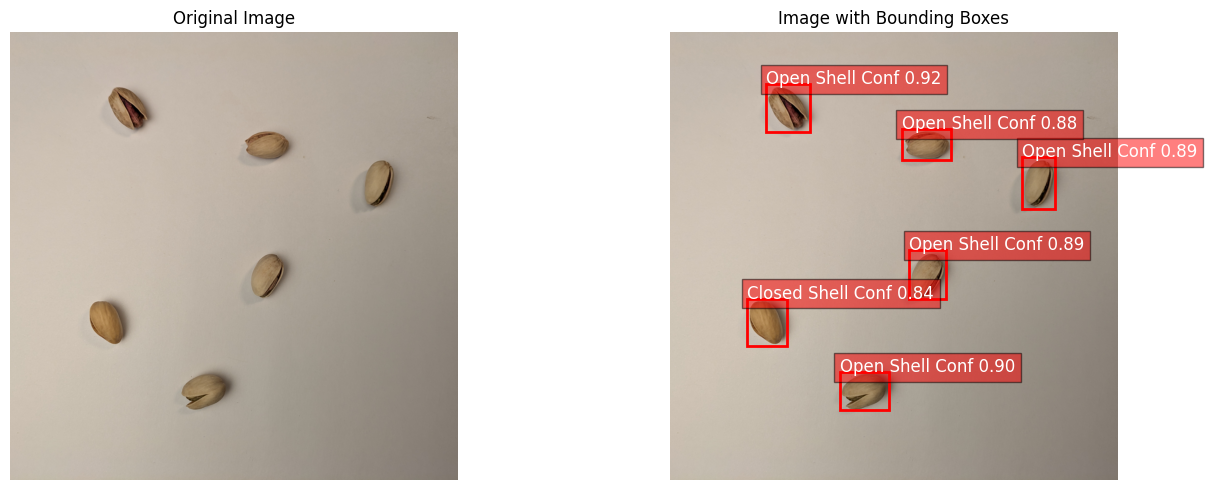

In [ ]:
import cv2
import matplotlib.pyplot as plt


results = model.predict("/content/PXL_20241204_072836927.jpg")

# Show results
results[0].show()

image_path = "/content/PXL_20241204_072836927.jpg"
image = cv2.imread(image_path)

# Convert the image from BGR to RGB (for proper display with Matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Display the original image in the first subplot
axes[0].imshow(image_rgb)
axes[0].axis('off')  # Turn off axis for the first image
axes[0].set_title('Original Image')  # Title for the original image

# Display the image with bounding boxes in the second subplot
axes[1].imshow(image_rgb)
for i in range(len(results[0].boxes)):  # Iterate over all detected boxes
    x1, y1, x2, y2 = results[0].boxes.xyxy[i].cpu().numpy()

    # Extract the class (cls) and confidence (conf)
    cls = int(results[0].boxes.cls[i].cpu().numpy())  # Convert class to int
    conf = results[0].boxes.conf[i].cpu().numpy()  # Get the confidence score

    # Get the class label (this can either be a number or a string depending on the model output)
    if cls == 0:
        label_name = 'Closed Shell'
    elif cls == 1:
        label_name = 'Open Shell'
    else:
        label_name = f'Class {cls}'  # Fallback if there are more classes

    # Define the color for the bounding box (e.g., red)
    color = (255, 0, 0)  # Red color for bounding box
    color = tuple(c / 255.0 for c in color)  # Convert to [0, 1] range

    # Draw the bounding box
    axes[1].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none'))

    # Display the label and confidence on the image
    label = f'{label_name} Conf {conf:.2f}'
    axes[1].text(x1, y1, label, fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

axes[1].axis('off')  # Turn off axis for the second image
axes[1].set_title('Image with Bounding Boxes')  # Title for the image with bounding boxes
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


image 1/1 /content/PXL_20241204_073633196.jpg: 640x640 1 Closed_shell, 13 Open_shells, 7.8ms
Speed: 4.1ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


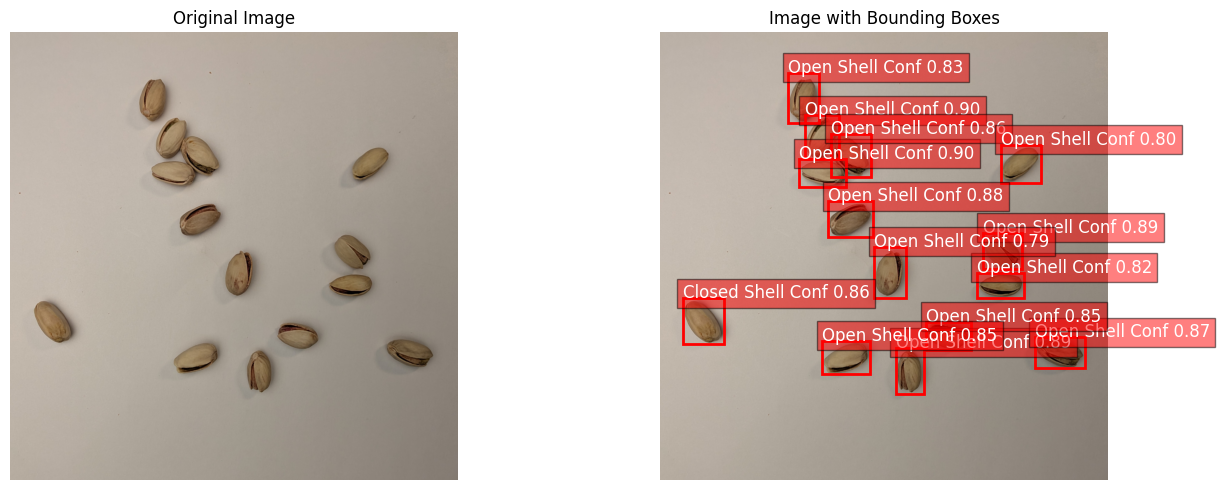

In [ ]:
import cv2
import matplotlib.pyplot as plt


results = model.predict("/content/PXL_20241204_073633196.jpg")

# Show results
results[0].show()

image_path = "/content/PXL_20241204_073633196.jpg"
image = cv2.imread(image_path)

# Convert the image from BGR to RGB (for proper display with Matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Display the original image in the first subplot
axes[0].imshow(image_rgb)
axes[0].axis('off')  # Turn off axis for the first image
axes[0].set_title('Original Image')  # Title for the original image

# Display the image with bounding boxes in the second subplot
axes[1].imshow(image_rgb)
for i in range(len(results[0].boxes)):  # Iterate over all detected boxes
    x1, y1, x2, y2 = results[0].boxes.xyxy[i].cpu().numpy()

    # Extract the class (cls) and confidence (conf)
    cls = int(results[0].boxes.cls[i].cpu().numpy())  # Convert class to int
    conf = results[0].boxes.conf[i].cpu().numpy()  # Get the confidence score

    # Get the class label (this can either be a number or a string depending on the model output)
    if cls == 0:
        label_name = 'Closed Shell'
    elif cls == 1:
        label_name = 'Open Shell'
    else:
        label_name = f'Class {cls}'  # Fallback if there are more classes

    # Define the color for the bounding box (e.g., red)
    color = (255, 0, 0)  # Red color for bounding box
    color = tuple(c / 255.0 for c in color)  # Convert to [0, 1] range

    # Draw the bounding box
    axes[1].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none'))

    # Display the label and confidence on the image
    label = f'{label_name} Conf {conf:.2f}'
    axes[1].text(x1, y1, label, fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

axes[1].axis('off')  # Turn off axis for the second image
axes[1].set_title('Image with Bounding Boxes')  # Title for the image with bounding boxes
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
results = model.predict("/content/Pista-Detection-1/test/images/IMG_5376_JPG.rf.a8e90bb1247cfe0c784f3a4a6e511d2f.jpg")

# Show results
results[0].show()


image 1/1 /content/Pista-Detection-1/test/images/IMG_5376_JPG.rf.a8e90bb1247cfe0c784f3a4a6e511d2f.jpg: 640x640 2 Closed_shells, 5 Open_shells, 10.6ms
Speed: 2.5ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


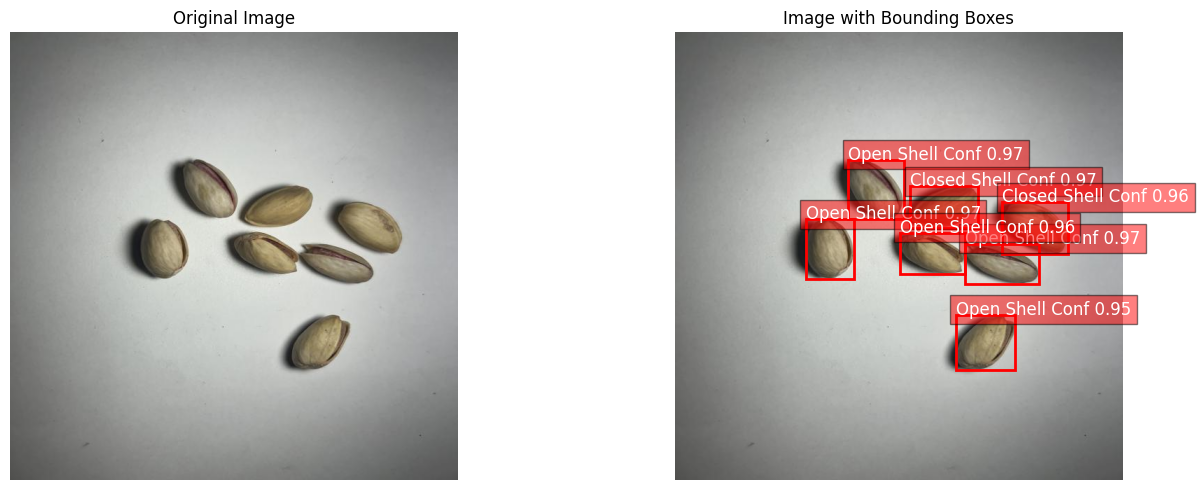

In [ ]:
import cv2
import matplotlib.pyplot as plt

image_path = "/content/Pista-Detection-1/test/images/IMG_5376_JPG.rf.a8e90bb1247cfe0c784f3a4a6e511d2f.jpg"
image = cv2.imread(image_path)

# Convert the image from BGR to RGB (for proper display with Matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Display the original image in the first subplot
axes[0].imshow(image_rgb)
axes[0].axis('off')  # Turn off axis for the first image
axes[0].set_title('Original Image')  # Title for the original image

# Display the image with bounding boxes in the second subplot
axes[1].imshow(image_rgb)
for i in range(len(results[0].boxes)):  # Iterate over all detected boxes
    x1, y1, x2, y2 = results[0].boxes.xyxy[i].cpu().numpy()

    # Extract the class (cls) and confidence (conf)
    cls = int(results[0].boxes.cls[i].cpu().numpy())  # Convert class to int
    conf = results[0].boxes.conf[i].cpu().numpy()  # Get the confidence score

    # Get the class label (this can either be a number or a string depending on the model output)
    if cls == 0:
        label_name = 'Closed Shell'
    elif cls == 1:
        label_name = 'Open Shell'
    else:
        label_name = f'Class {cls}'  # Fallback if there are more classes

    # Define the color for the bounding box (e.g., red)
    color = (255, 0, 0)  # Red color for bounding box
    color = tuple(c / 255.0 for c in color)  # Convert to [0, 1] range

    # Draw the bounding box
    axes[1].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none'))

    # Display the label and confidence on the image
    label = f'{label_name} Conf {conf:.2f}'
    axes[1].text(x1, y1, label, fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

axes[1].axis('off')  # Turn off axis for the second image
axes[1].set_title('Image with Bounding Boxes')  # Title for the image with bounding boxes
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
import os
best_model = YOLO('runs/detect/train2/weights/last.pt')
save_path = '/content/{HOME}/datasets/runs'
os.makedirs(save_path, exist_ok=True)  # This will create the directory if it doesn't exist

# Now save the model
best_model.save(f'{save_path}/best_model.pt')

**Prediction on random Image from the model**

In [ ]:
model = YOLO('runs/detect/train2/weights/last.pt')

import os
import random

random_file = random.choice(os.listdir(f"{dataset.location}/test/images"))
file_name = os.path.join(f"{dataset.location}/test/images", random_file)
results = model(file_name)
print(results[0])


image 1/1 /content/Pista-Detection-1/test/images/IMG_E5813_JPG.rf.9d56e283097417073d03c7c242cfeb5b.jpg: 640x640 1 Closed_shell, 4 Open_shells, 22.5ms
Speed: 2.7ms preprocess, 22.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Closed_shell', 1: 'Open_shell'}
obb: None
orig_img: array([[[ 91,  93,  93],
        [ 91,  93,  93],
        [ 91,  93,  93],
        ...,
        [115, 116, 114],
        [115, 116, 114],
        [115, 116, 114]],

       [[ 91,  93,  93],
        [ 91,  93,  93],
        [ 91,  93,  93],
        ...,
        [116, 117, 115],
        [115, 116, 114],
        [115, 116, 114]],

       [[ 91,  93,  93],
        [ 91,  93,  93],
        [ 91,  93,  93],
        ...,
        [116, 117, 115],
        [116, 117, 115],
        [115, 116, 114]],

       ...,

       [[ 98, 100, 100],
        [ 98, 100, 1

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the YOLO model
model = YOLO('runs/detect/train2/weights/last.pt')

# Randomly choose an image from the test dataset
random_file = random.choice(os.listdir(f"{dataset.location}/test/images"))
file_name = os.path.join(f"{dataset.location}/test/images", random_file)

# Run the model to get predictions on the selected image
results = model(file_name)

# Load the image
image = cv2.imread(file_name)

# Convert the image from BGR to RGB (for proper display with Matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a figure with 1 row and 2 columns for displaying the images side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Display the original image in the first subplot
axes[0].imshow(image_rgb)
axes[0].axis('off')  # Turn off axis for the first image
axes[0].set_title('Original Image')  # Title for the original image

# Display the image with bounding boxes in the second subplot
axes[1].imshow(image_rgb)
for i in range(len(results[0].boxes)):  # Iterate over all detected boxes
    x1, y1, x2, y2 = results[0].boxes.xyxy[i].cpu().numpy()

    # Extract the class (cls) and confidence (conf)
    cls = int(results[0].boxes.cls[i].cpu().numpy())  # Convert class to int
    conf = results[0].boxes.conf[i].cpu().numpy()  # Get the confidence score

    # Get the class label (this can either be a number or a string depending on the model output)
    if cls == 0:
        label_name = 'Closed Shell'
    elif cls == 1:
        label_name = 'Open Shell'
    else:
        label_name = f'Class {cls}'  # Fallback if there are more classes

    # Define the color for the bounding box (e.g., red)
    color = (255, 0, 0)  # Red color for bounding box
    color = tuple(c / 255.0 for c in color)  # Convert to [0, 1] range

    # Draw the bounding box
    axes[1].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none'))

    # Display the label and confidence on the image
    label = f'{label_name} Conf {conf:.2f}'
    axes[1].text(x1, y1, label, fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

axes[1].axis('off')  # Turn off axis for the second image
axes[1].set_title('Image with Bounding Boxes')  # Title for the image with bounding boxes

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the images side by side
plt.show()

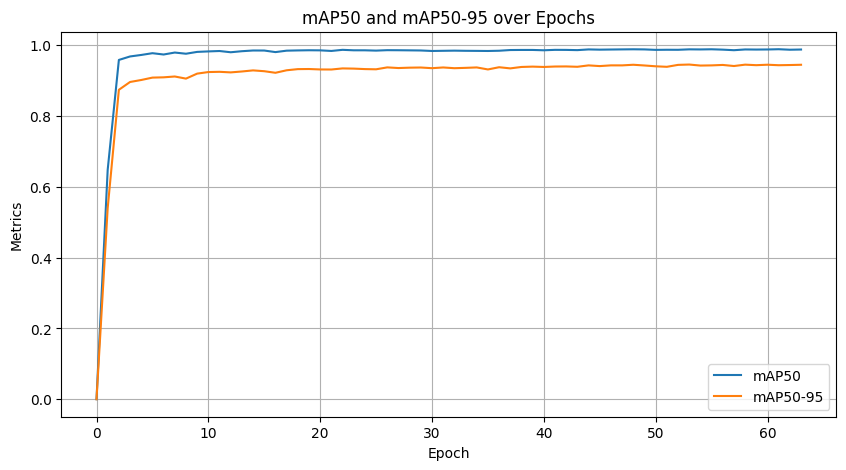

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
try:
    results = pd.read_csv('/content/runs/detect/train2/results.csv')
except FileNotFoundError:
    print("Error: results.csv not found. Make sure the file exists in the correct location.")
    exit()

results.columns = results.columns.str.strip()


plt.figure(figsize=(10, 5))
plt.plot(results['metrics/mAP50(B)'], label='mAP50', linestyle='-')
plt.plot(results['metrics/mAP50-95(B)'], label='mAP50-95', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('mAP50 and mAP50-95 over Epochs')
plt.legend()
plt.grid(True)
plt.show()

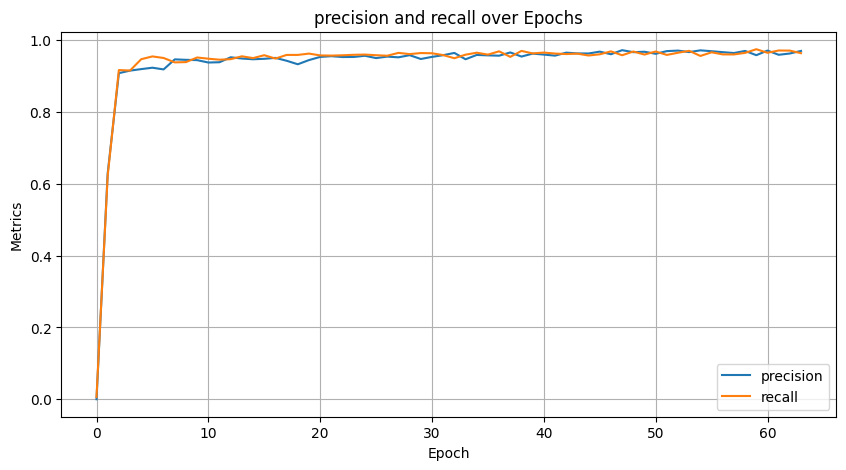

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(results['metrics/precision(B)'], label='precision', linestyle='-')
plt.plot(results['metrics/recall(B)'], label='recall', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('precision and recall over Epochs')
plt.legend()
plt.grid(True)
plt.show()

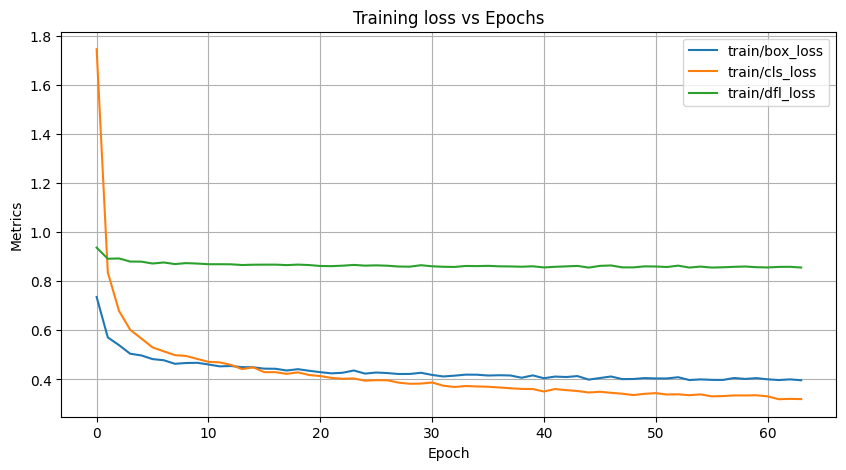

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(results['train/box_loss'], label='train/box_loss', linestyle='-')
plt.plot(results['train/cls_loss'], label='train/cls_loss', linestyle='-')
plt.plot(results['train/dfl_loss'], label='train/dfl_loss', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Training loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

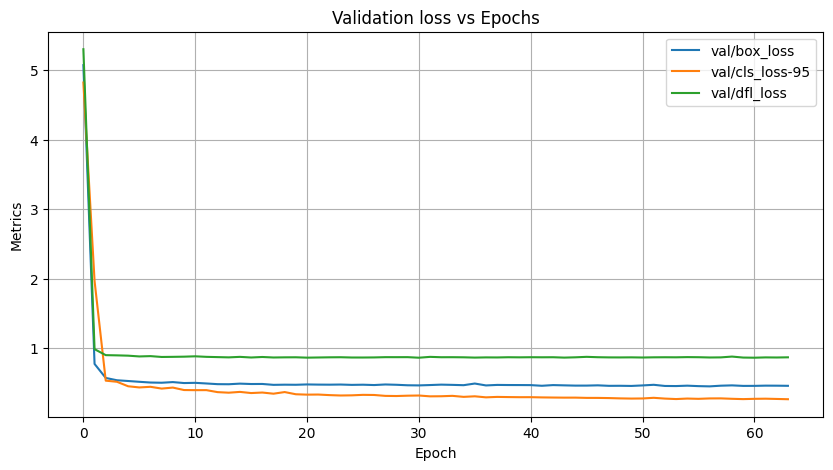

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(results['val/box_loss'], label='val/box_loss', linestyle='-')
plt.plot(results['val/cls_loss'], label='val/cls_loss-95', linestyle='-')
plt.plot(results['val/dfl_loss'], label='val/dfl_loss', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Validation loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

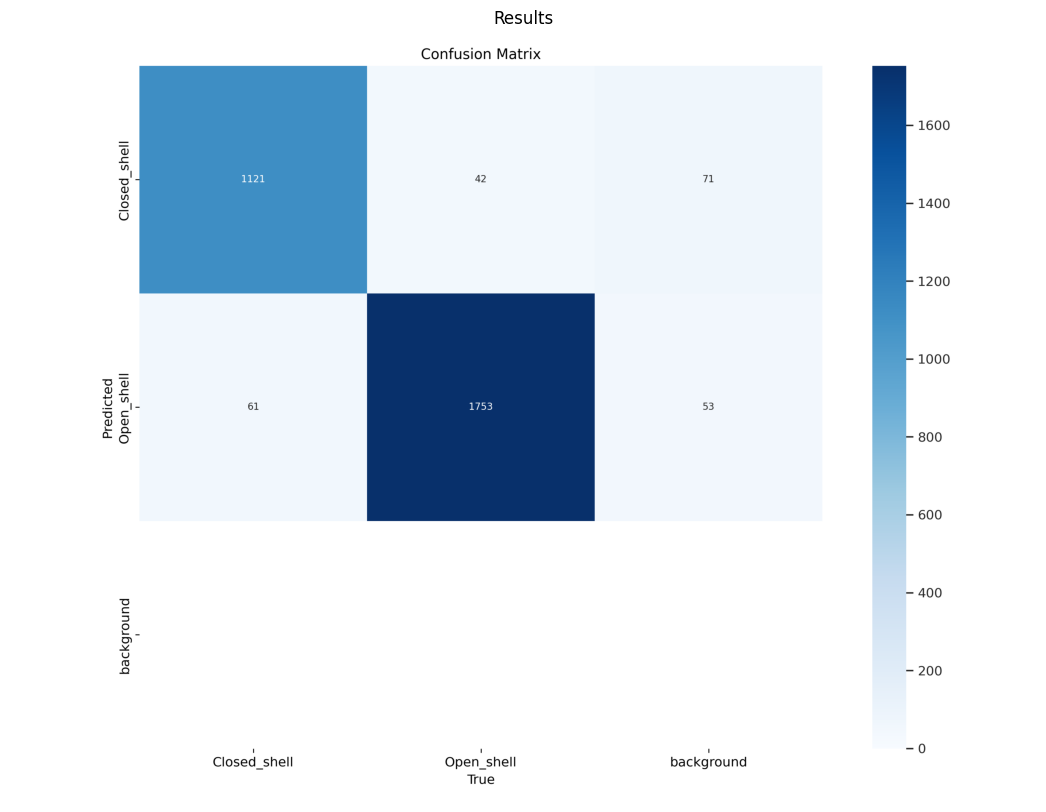

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = '/content/runs/detect/train2/confusion_matrix.png'
img = Image.open(image_path)

plt.figure(figsize=(20, 10))
plt.title('Results')
plt.imshow(img)
plt.axis('off')
plt.show()

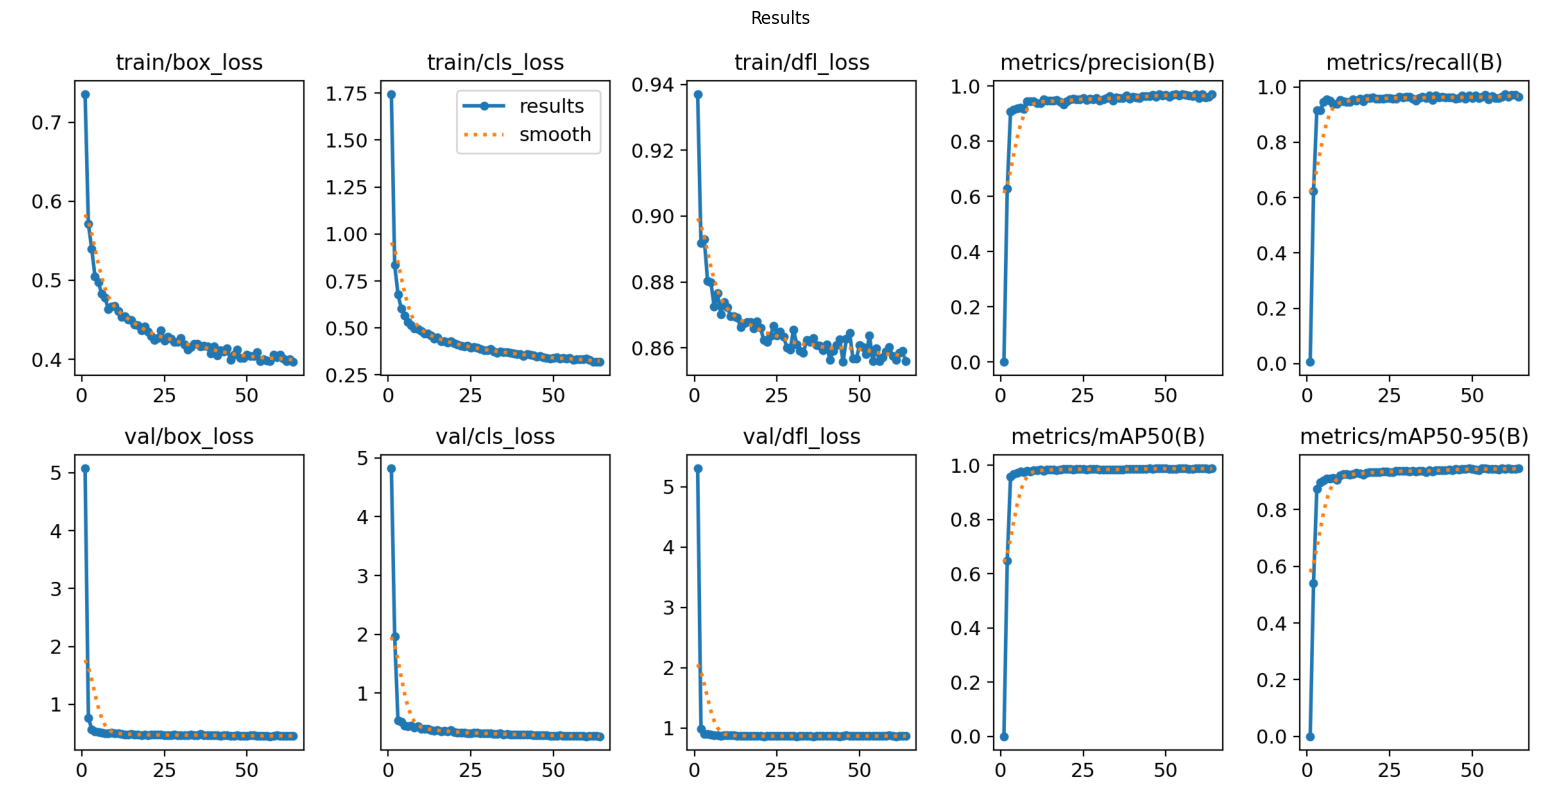

In [ ]:
image_path = '/content/runs/detect/train2/results.png'
img = Image.open(image_path)

plt.figure(figsize=(20, 10))
plt.title('Results')
plt.imshow(img)
plt.axis('off')
plt.show()

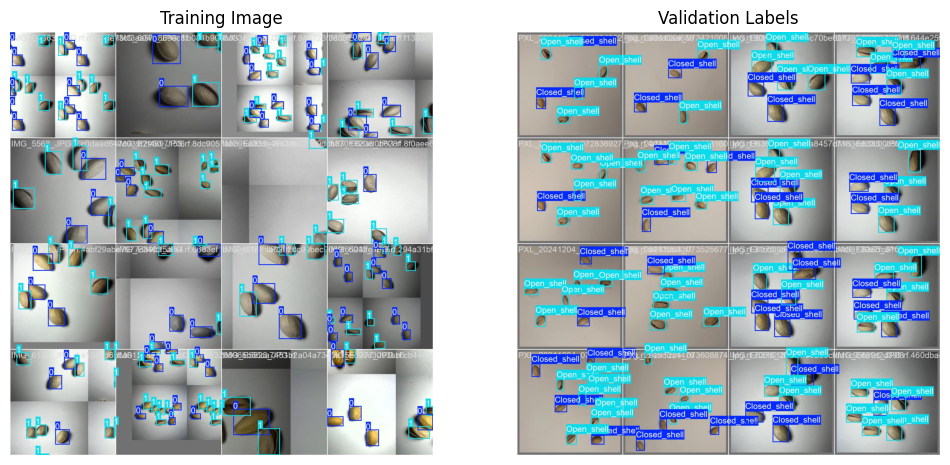

In [ ]:
# Load the images
train_image_path = '/content/runs/detect/train2/train_batch0.jpg'
val_labels_image_path = '/content/runs/detect/train2/val_batch0_labels.jpg'

train_image = Image.open(train_image_path)
val_labels_image = Image.open(val_labels_image_path)

# Create a plot with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the training image
axes[0].imshow(train_image)
axes[0].set_title('Training Image')
axes[0].axis('off')  # Hide axes

# Plot the validation labels image
axes[1].imshow(val_labels_image)
axes[1].set_title('Validation Labels')
axes[1].axis('off')  # Hide axes

# Show the plot
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

# Source folder (the folder you want to move)
source_folder = '/content/Pista-Detection-1'

# Destination folder (where you want to move it)
destination_folder = '/content/drive/MyDrive/Model/Custom_Yolov8n'

# Move the folder
shutil.move(source_folder, destination_folder)


'/content/drive/MyDrive/Model/Custom_Yolov8n/Pista-Detection-1'

In [ ]:
import shutil

# Source folder (the folder you want to move)
source_folder = '/content/runs'

# Destination folder (where you want to move it)
destination_folder = '/content/drive/MyDrive/Model/Custom_Yolov8n'

# Move the folder
shutil.move(source_folder, destination_folder)


'/content/drive/MyDrive/Model/Custom_Yolov8n/runs'

In [ ]:
import shutil

# Source folder (the folder you want to move)
source_folder = '/content/{HOME}'

# Destination folder (where you want to move it)
destination_folder = '/content/drive/MyDrive/Model/Custom_Yolov8n'

# Move the folder
shutil.move(source_folder, destination_folder)


'/content/drive/MyDrive/Model/Custom_Yolov8n/{HOME}'

In [ ]:
import shutil

# Source folder (the folder you want to move)
source_folder = '/content/yolov8n.pt'

# Destination folder (where you want to move it)
destination_folder = '/content/drive/MyDrive/Model/Custom_Yolov8n'

# Move the folder
shutil.move(source_folder, destination_folder)


'/content/drive/MyDrive/Model/Custom_Yolov8n/yolov8n.pt'

In [ ]:
import shutil

# Source folder (the folder you want to move)
source_folder = '/content/PXL_20241204_072836927.jpg'

# Destination folder (where you want to move it)
destination_folder = '/content/drive/MyDrive/Model/Custom_Yolov8n'

# Move the folder
shutil.move(source_folder, destination_folder)


'/content/drive/MyDrive/Model/Custom_Yolov8n/PXL_20241204_072836927.jpg'

In [ ]:
import shutil

# Source folder (the folder you want to move)
source_folder = '/content/PXL_20241204_073633196.jpg'

# Destination folder (where you want to move it)
destination_folder = '/content/drive/MyDrive/Model/Custom_Yolov8n'

# Move the folder
shutil.move(source_folder, destination_folder)


'/content/drive/MyDrive/Model/Custom_Yolov8n/PXL_20241204_073633196.jpg'


image 1/1 /content/Pista-Detection-1/test/images/IMG_E5956_JPG.rf.b7a0ae1c8065e1138581069630b0a6db.jpg: 640x640 5 Closed_shells, 5 Open_shells, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


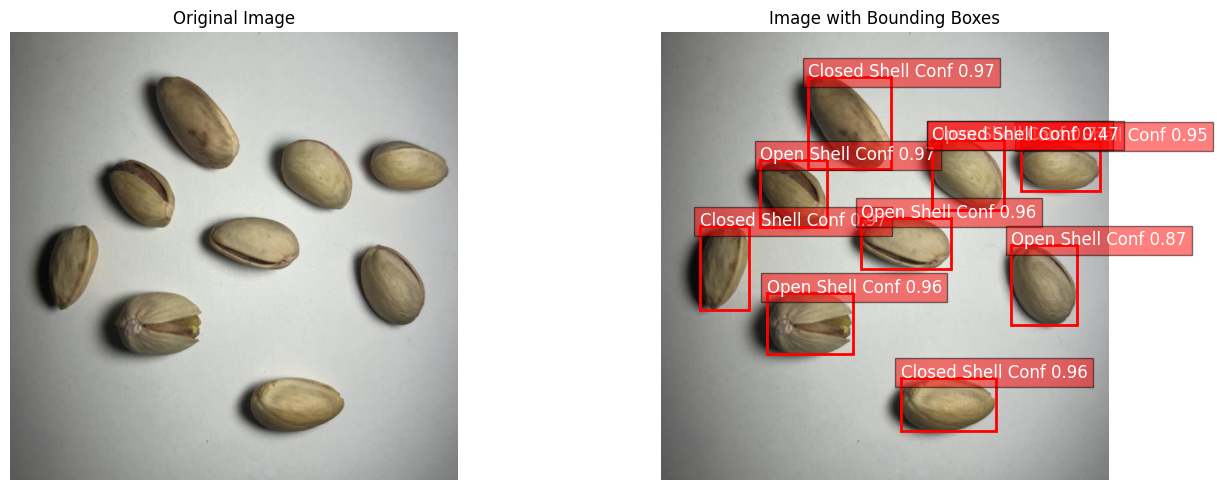

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the YOLO model
model = YOLO('runs/detect/train2/weights/last.pt')

# Randomly choose an image from the test dataset
random_file = random.choice(os.listdir(f"{dataset.location}/test/images"))
file_name = os.path.join(f"{dataset.location}/test/images", random_file)

# Run the model to get predictions on the selected image
results = model(file_name)

# Load the image
image = cv2.imread(file_name)

# Convert the image from BGR to RGB (for proper display with Matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a figure with 1 row and 2 columns for displaying the images side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Display the original image in the first subplot
axes[0].imshow(image_rgb)
axes[0].axis('off')  # Turn off axis for the first image
axes[0].set_title('Original Image')  # Title for the original image

# Display the image with bounding boxes in the second subplot
axes[1].imshow(image_rgb)
for i in range(len(results[0].boxes)):  # Iterate over all detected boxes
    x1, y1, x2, y2 = results[0].boxes.xyxy[i].cpu().numpy()

    # Extract the class (cls) and confidence (conf)
    cls = int(results[0].boxes.cls[i].cpu().numpy())  # Convert class to int
    conf = results[0].boxes.conf[i].cpu().numpy()  # Get the confidence score

    # Get the class label (this can either be a number or a string depending on the model output)
    if cls == 0:
        label_name = 'Closed Shell'
    elif cls == 1:
        label_name = 'Open Shell'
    else:
        label_name = f'Class {cls}'  # Fallback if there are more classes

    # Define the color for the bounding box (e.g., red)
    color = (255, 0, 0)  # Red color for bounding box
    color = tuple(c / 255.0 for c in color)  # Convert to [0, 1] range

    # Draw the bounding box
    axes[1].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none'))

    # Display the label and confidence on the image
    label = f'{label_name} Conf {conf:.2f}'
    axes[1].text(x1, y1, label, fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

axes[1].axis('off')  # Turn off axis for the second image
axes[1].set_title('Image with Bounding Boxes')  # Title for the image with bounding boxes

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the images side by side
plt.show()